In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gym
import random
from collections import defaultdict
import itertools
import cv2
import plotting

matplotlib.style.use('ggplot')

In [2]:
envids = [spec.id for spec in gym.envs.registry.all()]
envs_ram = []
envs_pixel = []
for envid in envids:
    if '-ram-' in envid and '0' in envid:
        envs_ram.append(envid)
    elif '0' in envid:
        envs_pixel.append(envid)
        


In [43]:
env = gym.make(random.choice(envs_pixel))
state = env.reset()

In [44]:
action0 = 0  # do nothing
obs0, reward0, terminal, info = env.step(action0)
print("Before processing: " + str(np.array(obs0).shape))

Before processing: (210, 160, 3)


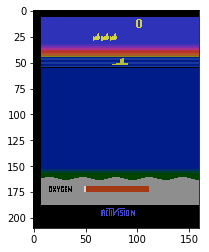

In [45]:
plt.imshow(np.array(obs0))
plt.show()

In [46]:
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(84,84,1))

After processing: (84, 84, 1)


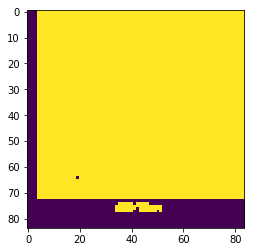

In [47]:
obs0 = preprocess(obs0)
print("After processing: " + str(np.array(obs0).shape))
plt.imshow(np.array(np.squeeze(obs0)))
plt.show()

In [73]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [99]:
def q_learning(env, num_episodes, discount_factor=0.9, alpha=0.618, epsilon=0.1):
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        state = preprocess(state)
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            state = np.reshape(state,-1)
            state = tuple(state)
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

#             Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            next_state = preprocess(next_state)
            next_state = np.reshape(next_state, -1)
            next_state = tuple(next_state)
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats
    
    

In [102]:
Q, stats = q_learning(env, 10)

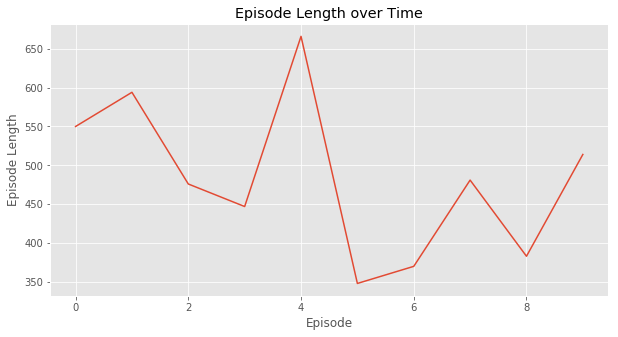

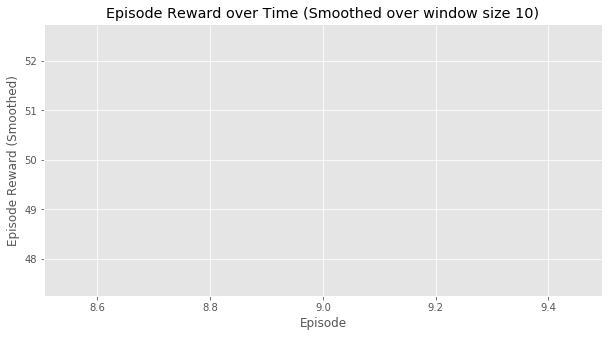

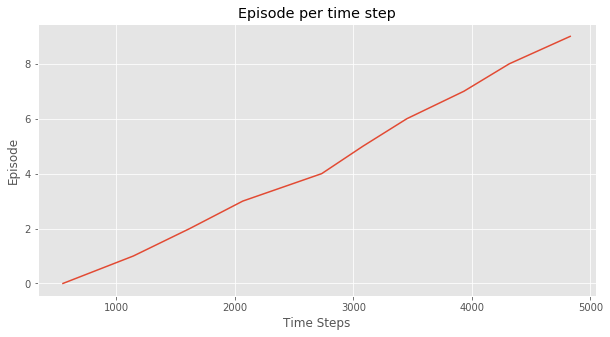

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [103]:
plotting.plot_episode_stats(stats)